# 2D Uplift model

This model uses a pressure boundary condition to force an uplift.

This model also utilises scaling our numbers into dimensionless units.


In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
import os

from unsupported.scaling import *
from unsupported.scaling import nonDimensionalize as nd

/home/julian/codes/clean_uw/unsupported/scaling/__init__.py:11: UserWarning: 

The scaling module is not supported.

It requires 'pint' as a dependency.

You can install pint by running:

'pip install pint' in a terminal

Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


In [2]:
# reference units
KL_meters = 100e3 * u.meter
K_viscosity = (1e16 * u.pascal * u.second).to_base_units()
K_density = (3.3e3 * u.kilogram / (u.meter)**3 ).to_base_units()

In [3]:
KM_kilograms = K_density * KL_meters**3
KT_seconds = KM_kilograms / ( KL_meters * K_viscosity )
K_substance = 1. * u.mole
Kt_degrees = 1. * u.kelvin

scaling = {"[time]": KT_seconds,
           "[length]": KL_meters, 
           "[mass]": KM_kilograms,
           "[temperature]": Kt_degrees,
           "[substance]": K_substance}

In [4]:
# all nondimensional units
gravity = nd(9.81 * u.meter / u.second**2, scaling)
density = nd( 3300 * u.kilogram / u.meter**3, scaling)
viscosity = nd( 1e22 * u.Pa * u.sec, scaling)
bulk_visc = nd( 1e11 * u.Pa *u.sec, scaling)

In [25]:
gravity, density, viscosity, bulk_visc

(1.0683089999999999e-09, 1.0, 1000000.0, 9.999999999999999e-06)

In [5]:
Lx = nd( 100e3 * u.meter, scaling)
Ly = nd(  60e3 * u.meter, scaling)
dx = nd(   5e3 * u.meter, scaling)
dy = nd(   5e3 * u.meter, scaling)
center = nd(50e3 * u.meter, scaling)
width = nd(3e3*u.meter, scaling)

In [6]:
lithostaticPressure = 0.6*Ly*density*gravity

In [7]:
resUnit = 5
boxLength = Lx
boxHeight = Ly
elType = "Q1/dQ0"
resx = 100
resy = 60
minCoord = [0.,0.]
maxCoord = [boxLength,boxHeight]

In [8]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elType), 
                                 elementRes  = (resx, resy), 
                                 minCoord    = minCoord, 
                                 maxCoord    = maxCoord )

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
stressField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3 )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

In [9]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
stressField.data[:] = [0.0,0.0,0.0]

for ii in mesh.specialSets['MinJ_VertexSet']:
    coord = mesh.data[ii]
    stressField.data[ii] = [0.0,-lithostaticPressure*(1.+0.2*np.exp((-1/width*(coord[0]-center)**2))), 0.0]

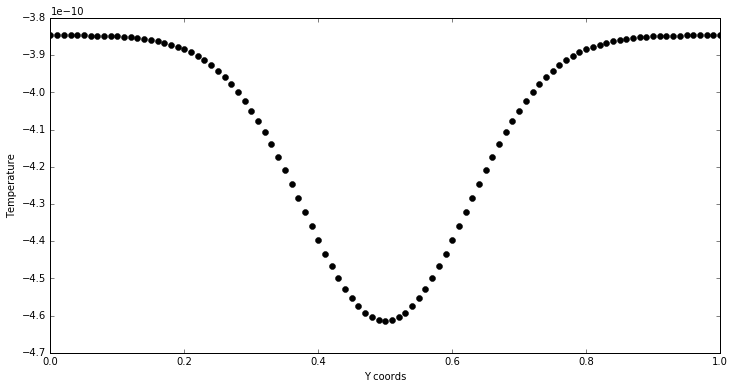

In [10]:
# visualise the bottom stress condition
if uw.rank() == 0:
    uw.matplotlib_inline()
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pyplot.ion()
    pylab.rcParams[ 'figure.figsize'] = 12, 6
    xcoord = mesh.data[mesh.specialSets['MinJ_VertexSet'].data][:,0]
    stress = stressField.data[mesh.specialSets['MinJ_VertexSet'].data][:,1]
    pyplot.plot( xcoord, stress, 'o', color = 'black', label='numerical') 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()

In [11]:
# Initialise a swarm.
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
advector= uw.systems.SwarmAdvector(velocityField, swarm, order=2)

# Add a data variable which will store an index to determine material.
materialVariable = swarm.add_variable( dataType="double", count=1 )

# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# Populate.
swarm.populate_using_layout( layout=swarmLayout )

# material 0 - compressible Lambda=10, density = 0
# material 1 - incompressible Lambda=0, density = 1

materialVariable.data[:]=0
for index,coord in enumerate(swarm.particleCoordinates.data):
    if coord[1] < boxHeight*0.6:
        materialVariable.data[index]=1

# population control regulars particle creation and deletion
# important for inflow/outflow problems
population_control = uw.swarm.PopulationControl(swarm, 
                                                aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,
                                                particlesPerCell=20)

# build tracer swarm for fluid level - only 1 particle
mswarm = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
msAdvector= uw.systems.SwarmAdvector(velocityField, mswarm, order=2)

# initial height at 'air' level
particleCoordinates = np.zeros((1,2))
particleCoordinates[:,0] = 0.5*Lx
particleCoordinates[:,1] = 0.6*Ly
ignore=mswarm.add_particles_with_coordinates(particleCoordinates)

In [24]:
Lx, Ly, boxHeight

(1.0, 0.6000000000000001, 0.6000000000000001)


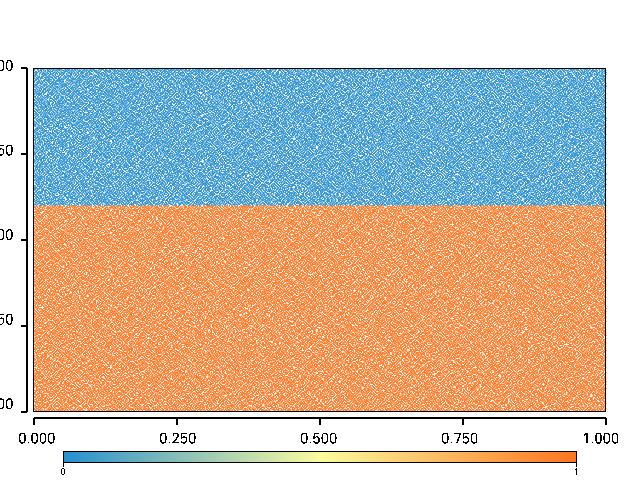

In [12]:
fig1 = glucifer.Figure(rulers=True, boundingBox=((0.0, 0.0), (Lx, Ly)))
fig1.append( glucifer.objects.Points(mswarm, colourBar=False ) )
fig1.append( glucifer.objects.Points(swarm, materialVariable, fn_size=2. ) )


fig1.show()

In [13]:
# lambdaFn is created for pseudo compressible air layer
lambdaFn = uw.function.branching.map( fn_key=materialVariable, 
                                    mapping={ 0: 1/bulk_visc, 1: 0.0 } )

densityFn = uw.function.branching.map( fn_key=materialVariable, 
                                    mapping={ 0: 0.0, 1: density } )

forceFn = densityFn * (0.0,-gravity)

In [14]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]
allWalls = iWalls + jWalls

# Now, using these sets, decide which degrees of freedom (on each node) should be considered Dirichlet.
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (iWalls, jWalls-bottomWall) )

# add neumann bcs
nbc      = uw.conditions.NeumannCondition( flux=stressField, variable = velocityField, 
                                             nodeIndexSet = bottomWall )

In [15]:
# setup solver
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [stokesBC, nbc],
                               fn_viscosity  = viscosity, 
                               fn_bodyforce  = forceFn,
                               fn_one_on_lambda = lambdaFn )
solver = uw.systems.Solver( stokesPIC )

In [16]:
# setup analysis function
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )
velmag = fn.math.sqrt(vdotv)

In [17]:
steps         = 0
finalTimestep = 3

fieldDict = {'velocity':velocityField, 'pressure':pressureField}
swarmDict = {'material':materialVariable}

In [18]:
prefix='uplift/'
if prefix is None:
    prefix=''
else:
    try:
        import os
        if not os.path.exists("./"+prefix+"/"):
            os.makedirs("./"+prefix+'/')
    except:
        raise

outfile = open(prefix+'buildMount.txt', 'w+')
string = "steps, timestep, vrms, peak height"
print(string)
outfile.write( string+"\n")

# initialise loop
dt = -1
h1 = mswarm.particleCoordinates.data[:,1].copy()

while steps<finalTimestep:
    # Get solution
    solver.solve()
    
    # calculate metrics
    v2int = v2sum_integral.evaluate()[0]
    vol   = volume_integral.evaluate()[0]
    
    # get time step first time around
    if dt < 0:
        dt = advector.get_max_dt()
    h0 = h1.copy() # NOTE the copy()
    
    # Advect particles   
    advector.integrate(dt)  
    msAdvector.integrate(dt)
    
    # update peak heigh
    h1 = mswarm.particleCoordinates.data[:,1]
    
    diffH = h1-h0
    string = "{}, {}, {}, {}".format(steps,
                                     Dimensionalize(dt, scaling, u.year),
                                     Dimensionalize(np.sqrt(v2int/vol), scaling, u.cm/u.year),
                                     Dimensionalize(diffH,scaling, u.metre)[0] )
    print(string)
    outfile.write(string+"\n")

        
    # population control
    population_control.repopulate()
    fig1.save(prefix+"particals-"+str(steps)+".png")
    
    steps += 1


outfile.close()

steps, timestep, vrms, peak height
0, 83095.6140903 year, 0.260685837972 centimeter / year, 301.546427502 meter
1, 83095.6140903 year, 0.238765403294 centimeter / year, 272.08723944 meter
2, 83095.6140903 year, 0.223245291046 centimeter / year, 245.140173362 meter


In [19]:
cm_per_year = Dimensionalize(1,scaling,u.centimeter/u.year)

In [20]:
# note, scaling by the 'Quantity' object is slow, use the magnitude insead
type(cm_per_year.magnitude)

float


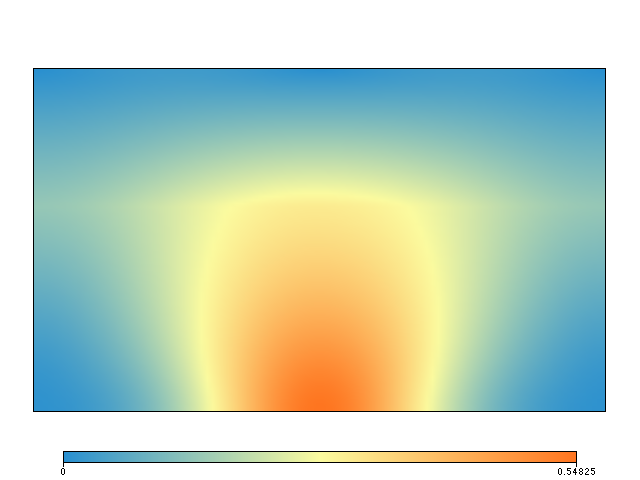

In [21]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.Surface(mesh, cm_per_year.magnitude*velmag) )

fig2.show()


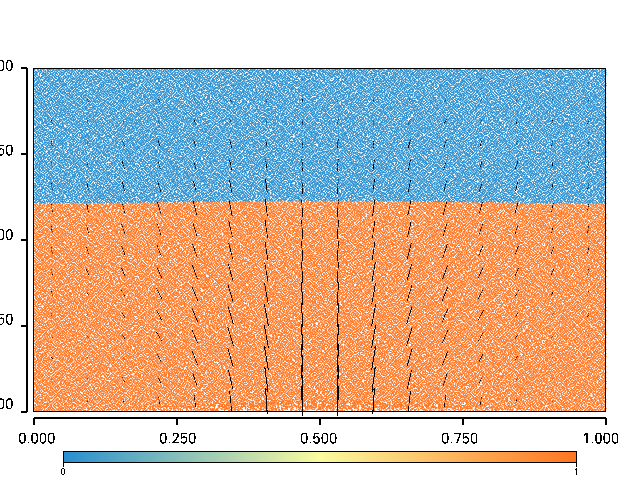

In [22]:
fig1.append( glucifer.objects.VectorArrows(mesh, cm_per_year.magnitude*0.1*velocityField) )
fig1.show()

In [23]:
# for testing purposes
dimensionalise=(diffH*Dimensionalize(1,scaling,u.meter))
if np.fabs(dimensionalise.magnitude-245.140) > 0.05*245.140:
    raise RuntimeError("Height of passive tracer outside expected 5% tolerance")
